In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [47]:
data = pd.read_csv('real-wages.csv')
data.head()

,Year,daily wages
0,1260,4.41
1,1261,4.63
2,1262,4.38
3,1263,4.52
4,1264,4.42


In [48]:
data.isnull().sum()


Year           0
daily wages    0
dtype: int64

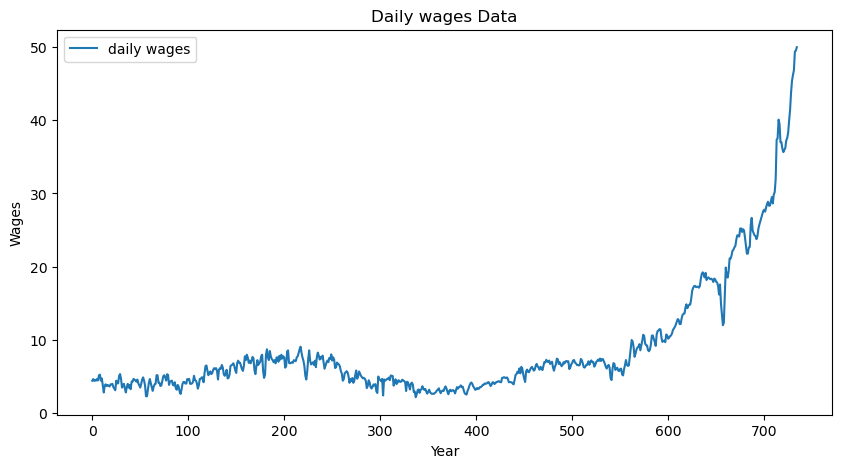

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(data['daily wages'], label='daily wages')
plt.title('Daily wages Data')
plt.xlabel('Year')
plt.ylabel('Wages')
plt.legend()
plt.show()

In [75]:
#data['']
#data.set_index('Year', inplace=True)
#419 rows dropped because pandas starts yearly todate format from 1677-01-01
data_dropped = data.iloc[420:].reset_index(drop=True)

data_dropped['Year'] = pd.to_datetime(data_dropped['Year'], format='%Y')

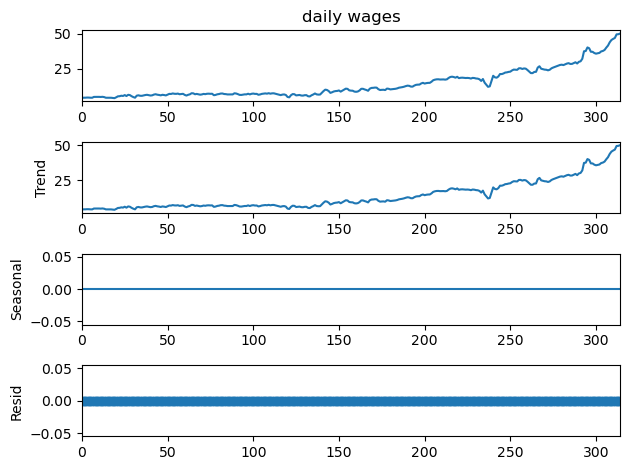

In [76]:
# Step 4: Decompose Time Series
decomposition = seasonal_decompose(data_dropped['daily wages'], model='additive', period=1)
decomposition.plot()
plt.show()

In [77]:
# Step 5: Stationarity Check
result = adfuller(data_dropped['daily wages'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 3.843777909435369
p-value: 1.0


In [78]:
# Apply log transformation and differencing
data_dropped['Log_Wages'] = np.log(data_dropped['daily wages'])
data_dropped['Log_Differenced_Wages'] = data_dropped['Log_Wages'].diff().dropna()

# Perform the ADF test again
result = adfuller(data_dropped['Log_Differenced_Wages'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -8.94714692335907
p-value: 8.92487888028938e-15


In [79]:
data_dropped = data_dropped.dropna()
data_dropped.head()

,Year,daily wages,Log_Wages,Log_Differenced_Wages
1,1681-01-01,4.23,1.442202,0.038559
2,1682-01-01,4.24,1.444563,0.002361
3,1683-01-01,4.34,1.467874,0.023311
4,1684-01-01,4.32,1.463255,-0.004619
5,1685-01-01,4.22,1.439835,-0.023420


In [87]:
# Step 6: Split Data
train_size = int(len(data_dropped) * 0.7)
train, test = data_dropped[:train_size], data_dropped[train_size:]


In [88]:
# Step 7: Model Selection (ARIMA Model)
model = ARIMA(train['Log_Differenced_Wages'], order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())


                                 SARIMAX Results                                 
Dep. Variable:     Log_Differenced_Wages   No. Observations:                  219
Model:                    ARIMA(5, 1, 0)   Log Likelihood                 265.779
Date:                   Wed, 22 May 2024   AIC                           -519.558
Time:                           21:50:15   BIC                           -499.251
Sample:                                0   HQIC                          -511.356
                                   - 219                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6301      0.070     -9.041      0.000      -0.767      -0.494
ar.L2         -0.6424      0.076     -8.407      0.000      -0.792      -0.493
ar.L3         -0.5896      0

C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [89]:
#sowed an error 
#ValueError: You must specify a period or x must be a pandas object with a period index or a datetime index with a freq not set to none

In [94]:
# Step 7: Forecast
forecast = model_fit.forecast(steps=int(len(test)+2))
test['Forecast'] = forecast

C:\Users\hunsu\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hunsu\AppData\Local\Temp\ipykernel_12396\107702378.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Forecast'] = forecast


In [95]:
print(len(test['Log_Differenced_Wages'].dropna()))
print(len( test['Forecast'].dropna()))

95
95


In [98]:

# Step 8: Evaluate Model
mse = mean_squared_error(test['Log_Differenced_Wages'].dropna(), test['Forecast'].dropna())
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0029768325135444726


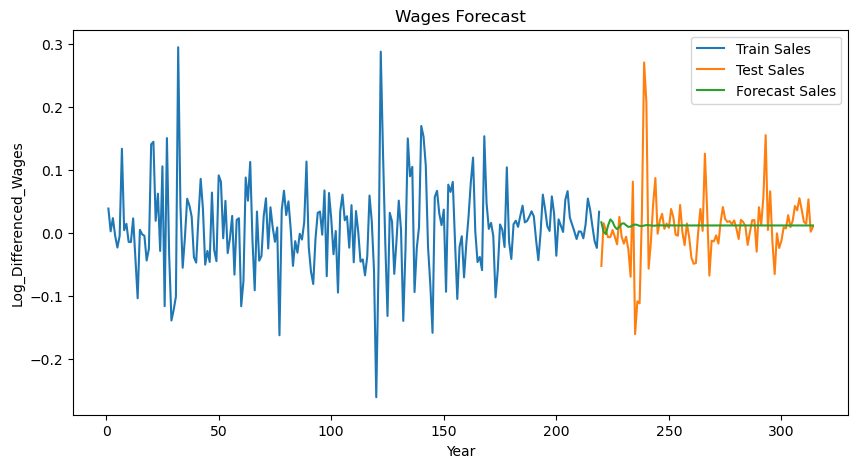

In [99]:
# Step 9: Plot Forecast
plt.figure(figsize=(10, 5))
plt.plot(train['Log_Differenced_Wages'], label='Train Sales')
plt.plot(test['Log_Differenced_Wages'], label='Test Sales')
plt.plot(test['Forecast'], label='Forecast Sales')
plt.title('Wages Forecast')
plt.xlabel('Year')
plt.ylabel('Log_Differenced_Wages')
plt.legend()
plt.show()